# 用神经网络思想实现Logistic回归

欢迎来到你的第一个编程作业！ 你将学习如何建立逻辑回归分类器用来识别猫。 这项作业将引导你逐步了解神经网络的思维方式，同时磨练你对深度学习的直觉。


**说明：**
除非指令中明确要求使用，否则请勿在代码中使用循环（for / while）。

**你将学习以下内容：**
* 建立学习算法的一般架构，包括：
	* 	初始化参数
	* 	计算损失函数及其梯度
	* 	使用优化算法（梯度下降）
* 按正确的顺序将以上所有三个功能集成到一个主模型上。



## 1- 安装包##

首先，让我们运行下面的单元格，以导入作业中所需的包。
* [numpy](www.numpy.org) 是Python科学计算的基本包。
* [h5py](http://www.h5py.org)是一个常用的包，可以处理存储为H5文件格式的数据集。
* [matplotlib](http://matplotlib.org)是一个著名的Python图形库。
* 这里最后通过[PIL]（http://www.pythonware.com/products/pil/）和[scipy](https://www.scipy.org/) 使用你自己的图片去测试模型效果。

In [1]:
cd ../data/L1W2T2/

g:\deep learning\deeplearning.ai\data\L1W2T2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import os
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

## 2- 问题概述##

**问题说明**：你将获得一个包含以下内容的数据集（"data.h5"）：
*      标记为cat（y = 1）或非cat（y = 0）的**m_train**训练图像集
*      标记为cat或non-cat的**m_test**测试图像集
*      图像维度为（num_px，num_px，3），其中3表示3个通道（RGB）。 因此，每个图像都是正方形（高度= num_px）和（宽度= num_px）。

你将构建一个简单的图像识别算法，该算法可以将图片正确分类为猫和非猫。
让我们熟悉一下数据集吧， 首先通过运行以下代码来加载数据。

In [3]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

我们在图像数据集（训练和测试）的末尾添加了"_orig"，以便对其进行预处理。 预处理后，我们将得到train_set_x和test_set_x（标签train_set_y和test_set_y不需要任何预处理）。

train_set_x_orig和test_set_x_orig的每一行都是代表图像的数组。 你可以通过运行以下代码来可视化示例。 还可以随意更改`index`值并重新运行以查看其他图像。

y = [0], it's a 'non-cat' picture.


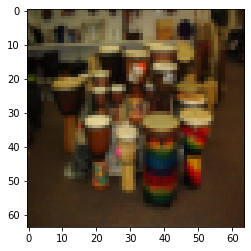

In [4]:
# Example of a picture
index = 5
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

深度学习中的许多报错都来自于矩阵/向量尺寸不匹配。 如果你可以保持矩阵/向量的尺寸不变，那么将消除大多错误。

**练习：** 查找以下各项的值：
*      m_train（训练集示例数量）
*      m_test（测试集示例数量）
*      num_px（=训练图像的高度=训练图像的宽度）

请记住，“ train_set_x_orig”是一个维度为（m_train，num_px，num_px，3）的numpy数组。 例如，你可以通过编写“ train_set_x_orig.shape [0]”来访问“ m_train”。

In [5]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**预期输出**：
训练集数量：m_train = 209
测试集数量：m_test = 50
每个图像的高度/宽度：num_px = 64
每个图像的大小：（64，64，3）
train_set_x维度：（209、64、64、3）
trainsety维度：（1，209）
test_set_x维度：（50、64、64、3）
test_set_y维度：（1，50）

为了方便起见，你现在应该以维度(num_px $*$ num_px $*$ 3, 1)的numpy数组重塑维度（num_px，num_px，3）的图像。 此后，我们的训练（和测试）数据集是一个numpy数组，其中每列代表一个展平的图像。 应该有m_train（和m_test）列。

**练习：** 重塑训练和测试数据集，以便将大小（num_px，num_px，3）的图像展平为单个形状的向量(num\_px $*$ num\_px $*$ 3, 1)。

当你想将维度为（a，b，c，d）的矩阵X展平为形状为(b$*$c$*$d, a)的矩阵X_flatten时的一个技巧是：
```python
X_flatten = X.reshape（X.shape [0]，-1）.T     ＃ 其中X.T是X的转置矩阵
```

In [6]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


**预期输出**：
train_set_x_flatten维度：（12288，209）
trainsety维度：（1，209）
test_set_x_flatten维度：（12288，50）
test_set_y维度：（1，50）
重塑后的检查维度：[17 31 56 22 33]

为了表示彩色图像，必须为每个像素指定红、绿、蓝色通道（RGB），因此像素值实际上是一个从0到255的三个数字的向量。

机器学习中一个常见的预处理步骤是对数据集进行居中和标准化，这意味着你要从每个示例中减去整个numpy数组的均值，然后除以整个numpy数组的标准差。但是图片数据集则更为简单方便，并且只要将数据集的每一行除以255（像素通道的最大值），效果也差不多。

在训练模型期间，你将要乘以权重并向一些初始输入添加偏差以观察神经元的激活。然后，使用反向梯度传播以训练模型。但是，让特征具有相似的范围以至渐变不会爆炸是非常重要的。具体内容我们将在后面的教程中详细学习！

开始标准化我们的数据集吧！

In [7]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

**你需要记住的内容：**

预处理数据集的常见步骤是：
* 找出数据的尺寸和维度（m_train，m_test，num_px等）
* 重塑数据集，以使每个示例都是大小为（num_px \ * num_px \ * 3，1）的向量
* “标准化”数据

## 3- 学习算法的一般架构##

现在是时候设计一种简单的算法来区分猫图像和非猫图像了。

你将使用神经网络思维方式建立Logistic回归。 下图说明了为什么“逻辑回归实际上是一个非常简单的神经网络！”

![Image Name](https://cdn.kesci.com/upload/image/q15kx21spv.png?imageView2/0/w/960/h/960)

**算法的数学表达式**：

For one example $x^{(i)}$:
$z^{(i)} = w^T x^{(i)} + b \tag{1}$
$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$ 
$$
\mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}
$$

The cost is then computed by summing over all training examples:
$$
J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}
$$
		
**关键步骤**：
在本练习中，你将执行以下步骤：
*      初始化模型参数
*      通过最小化损失来学习模型的参数
*      使用学习到的参数进行预测（在测试集上）
*      分析结果并得出结论

## 4- 构建算法的各个部分##

建立神经网络的主要步骤是：
1.定义模型结构（例如输入特征的数量）
2.初始化模型的参数
3.循环：
*      计算当前损失（正向传播）
*      计算当前梯度（向后传播）
*      更新参数（梯度下降）

你通常会分别构建1-3，然后将它们集成到一个称为“ model（）”的函数中。

### 4.1- 辅助函数

**练习**：使用“Python基础”中的代码，实现`sigmoid（）`。 如上图所示，你需要计算$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ 去预测。 使用np.exp（）。


In [8]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [9]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**预期输出**: 
sigmoid([0, 2]) = [0.5        0.88079708]

### 4.2- 初始化参数

**练习：** 在下面的单元格中实现参数初始化。 你必须将w初始化为零的向量。 如果你不知道要使用什么numpy函数，请在Numpy库的文档中查找np.zeros（）。

In [10]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim, 1))
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [11]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**预期输出**: 
w = [[0.]
[0.]]
b = 0


对于图像输入，w的维度为(num_px $\times$ num_px $\times$ 3, 1)。

### 4.3- 前向和后向传播

现在，你的参数已初始化，你可以执行“向前”和“向后”传播步骤来学习参数。

**练习：** 实现函数propagate（）来计算损失函数及其梯度。

**提示**：

正向传播：
* 得到X
* 计算$A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
* 计算损失函数：$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

你将要使用到以下两个公式：
$$
\frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}
$$
$$
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}
$$


In [12]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)            # compute activation
    cost = -1 / m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))         # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = 1 / m * np.dot(X, (A - Y).T)
    db = 1 / m * np.sum(A - Y)
    ### END CODE HERE ###
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [13]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


**预期输出**:
dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205

### d）优化函数
* 初始化参数。
* 计算损失函数及其梯度。
* 使用梯度下降来更新参数。

**练习：** 写下优化函数。 目标是通过最小化损失函数 $J$ 来学习 $w$ 和 $b$。 对于参数$\theta$，更新规则为$\theta = \theta - \alpha \text{ }  d\theta$，其中$\alpha$是学习率。


In [14]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [15]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print(costs)

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828
[6.000064773192205]


**预期输出**: 
w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828
[6.000064773192205]

**练习：** 上一个函数将输出学习到的w和b。 我们能够使用w和b来预测数据集X的标签。实现`predict（）`函数。 预测分类有两个步骤：
1.计算$\hat{Y} = A = \sigma(w^T X + b)$
2.将a的项转换为0（如果激活<= 0.5）或1（如果激活> 0.5），并将预测结果存储在向量“ Y_prediction”中。 如果愿意，可以在for循环中使用if / else语句。

In [16]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###

    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if A[0, i] <= 0.5:
            Y_prediction[0, i] = 0
        else:
            Y_prediction[0, i] = 1
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [17]:
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


**预期输出**: 
predictions = [[1. 1.]]


**你需要记住以下几点：**
你已经实现了以下几个函数：
* 初始化（w，b）
* 迭代优化损失以学习参数（w，b）：
	*     计算损失及其梯度
	*     使用梯度下降更新参数
* 使用学到的（w，b）来预测给定示例集的标签

## 5- 将所有功能合并到模型中##

现在，将所有构件（在上一部分中实现的功能）以正确的顺序放在一起，从而得到整体的模型结构。

**练习：** 实现模型功能，使用以下符号：
*      Y_prediction对测试集的预测
*      Y_prediction_train对训练集的预测
*      w，损失，optimize（）输出的梯度
		 

In [18]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

运行以下单元格训练模型：

In [19]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**预期输出**: 
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %

**评价**：训练准确性接近100％。 这是一个很好的情况：你的模型正在运行，并且具有足够的容量来适合训练数据。 测试误差为68％。 考虑到我们使用的数据集很小，并且逻辑回归是线性分类器，对于这个简单的模型来说，这实际上还不错。 但请放心，下周你将建立一个更好的分类器！

此外，你会看到该模型明显适合训练数据。 在本专业的稍后部分，你将学习如何减少过度拟合，例如通过使用正则化。 使用下面的代码（并更改`index`变量），你可以查看测试集图片上的预测。

y = 0, you predicted that it is a "cat" picture.


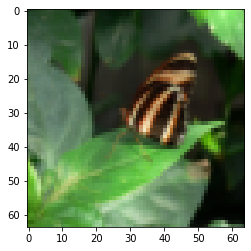

In [21]:
# Example of a picture that was wrongly classified.
index = 5
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

让我们绘制损失函数和梯度吧。

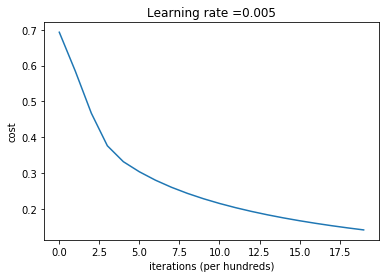

In [22]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**解释**：
损失下降表明正在学习参数。 但是，你看到可以在训练集上训练更多模型。 尝试增加上面单元格中的迭代次数，然后重新运行这些单元格。 你可能会看到训练集准确性提高了，但是测试集准确性却降低了。 这称为过度拟合。


## 6- 进一步分析（可选练习）##

祝贺你建立了第一个图像分类模型。 让我们对其进行进一步分析，并研究如何选择学习率$\alpha$。

#### 学习率的选择 ####

**提醒**：
为了使梯度下降起作用，你必须明智地选择学习率。 学习率$\alpha$决定我们更新参数的速度。 如果学习率太大，我们可能会“超出”最佳值。 同样，如果太小，将需要更多的迭代才能收敛到最佳值。 这也是为什么调整好学习率至关重要。

让我们将模型的学习曲线与选择的几种学习率进行比较。 运行下面的单元格。 这大约需要1分钟。 还可以尝试与我们初始化要包含的“ learning_rates”变量的三个值不同的值，然后看看会发生什么。

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



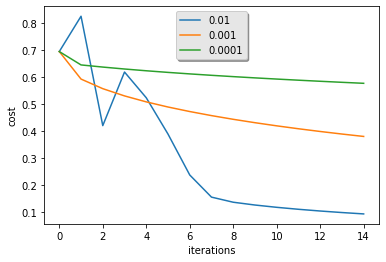

In [23]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

		
**解释**：
* 不同的学习率会带来不同的损失，因此会有不同的预测结果。
* 如果学习率太大（0.01），则成本可能会上下波动。 它甚至可能会发散（尽管在此示例中，使用0.01最终仍会以较高的损失值获得收益）。
* 较低的损失并不意味着模型效果很好。当训练精度比测试精度高很多时，就会发生过拟合情况。
* 在深度学习中，我们通常建议你：
	*      选择好能最小化损失函数的学习率。
	*      如果模型过度拟合，请使用其他方法来减少过度拟合。 （我们将在后面的教程中讨论。）



## 7-使用自己的图像进行测试（可选练习）##

祝贺你完成此作业。 你可以使用自己的图像并查看模型的预测输出。 要做到这一点：
     1.单击此笔记本上部栏中的 "File"，然后单击"Open" 以在Coursera Hub上运行。
     2.将图像添加到Jupyter Notebook的目录中，在"images"文件夹中
     3.在以下代码中更改图像的名称
     4.运行代码，检查算法是否正确（1 = cat，0 = non-cat）！

y = 1.0, your algorithm predicts a "cat" picture.


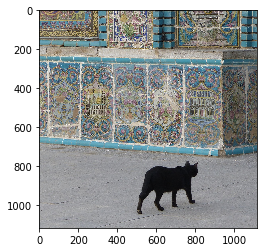

In [25]:
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
#my_image = "cat_in_iran.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = os.path.abspath('cat_in_iran.jpg')
image = np.array(plt.imread(fname))
my_image = np.array(Image.fromarray(image).resize((num_px,num_px))).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

**此作业要记住的内容：**

1. 预处理数据集很重要。
1. 如何实现每个函数：initialize（），propagation（），optimize（），并用此构建一个model（）。
1. 调整学习速率（这是“超参数”的一个示例）可以对算法产生很大的影响。 你将在本课程的稍后部分看到更多示例！

最后，如果你愿意，我们邀请你在此笔记本上尝试其他操作。 在尝试任何操作之前，请确保你正确提交。 提交后，你可以学习了解的包括：
*      发挥学习率和迭代次数
*      尝试不同的初始化方法并比较结果
*      测试其他预处理（将数据居中，或将每行除以其标准偏差）

参考书目：
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c